## Создание датасета

In [ ]:
import os
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from matplotlib import cm
import random
import string
import os, errno

def createCatalog(directory):
    try:
      os.makedirs(directory)
    except OSError as e:
      if e.errno != errno.EEXIST:
          raise

classifications = ['Display', 'Sans Serif', 'Serif', 'Monospaced', 'Handwritten', 'Calligraphic', 'Brushed Script', 'Handrawn', 'Script']
classifications = ['High Contrast', 'None High Contrast']
classifications = ['Condensed', 'Narrow', 'Wide']
# handwritten = ['Handwritten', 'Calligraphic', 'Brushed Script', 'Handrawn', 'Script']

for i in classifications:
  path = '/currentData/' + str(i)
  createCatalog(path)
# for i in handwritten[1:]:
#   path = '/currentData/' + str(i)
#   os.rmdir(path)

def generateRandomSample(fontPath, picSize=(200,50)):
  im = Image.new('RGB', picSize, color=('#FFFFFF'))
  font = ImageFont.truetype(fontPath, size=30)
  draw_text = ImageDraw.Draw(im)
  draw_text.text(
      (5, 5),
      generate_random_string(20),
      font=font,
      fill='#000000')
  return im


def generate_random_string(length):
  letters = string.ascii_letters
  rand_string = ''.join(random.choice(letters) for i in range(length))
  # print("Random string of length", length, "is:", rand_string)
  return rand_string

ratio = [43,59, 47]
num_skipped = 0
cnt = 0
for idx, folder_name in enumerate(classifications):
    folder_path = os.path.join("/content/drive/MyDrive/colabData/fontData/data/txtWidth/", folder_name)
    cnt = 0
    for fname in os.listdir(folder_path):
        cnt += 1
        fpath = os.path.join(folder_path, fname)
        # print(fpath)
        # print('/content/drive/MyDrive/colabData/fontData/data/img/'+folder_name+'/'+fname[:-4]+'.png')
        # fullName = '/content/drive/MyDrive/colabData/fontData/data/img/'+folder_name+'/'+fname[:-4]+'.jpg'
        samples = 20
        quantity = int(max(ratio)/ratio[idx])
        for i in range(samples*quantity):
          generateRandomSample(fpath).save('/currentData/'+folder_name+'/'+fname[:-4]+str(i)+'.jpg')
          # print("!")
    #     if cnt == 5:
    #       break
    # break
    print('Подготовлено шрифтов типа {}: {} в количестве {}x{} экземпляров на один шрифт'.format(folder_name, cnt, samples, quantity))
        # generateRandomSample(fpath).save('/content/drive/MyDrive/colabData/fontData/data/img/'+folder_name+fname[:-4]+'.png')
#         try:
#             fobj = open(fpath, "rb")
#             is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
#         finally:
#             fobj.close()

#         if not is_jfif:
#             num_skipped += 1
#             # Delete corrupted image
#             os.remove(fpath)

# print("Deleted %d images" % num_skipped)

Подготовлено шрифтов типа Condensed: 43 в количестве 20x1 экземпляров на один шрифт
Подготовлено шрифтов типа Narrow: 59 в количестве 20x1 экземпляров на один шрифт
Подготовлено шрифтов типа Wide: 47 в количестве 20x1 экземпляров на один шрифт


In [ ]:
# Setup
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
catalog = '/content/drive/MyDrive/colabData/fontData/data/classification/imgNormal'
catalog = '/currentData'
# folderNames = ['Display', 'Sans Serif', 'Serif', 'Monospaced', 'Handwritten']
folderNames = classifications

In [ ]:
import os

num_skipped = 0
for folder_name in folderNames:
    folder_path = os.path.join(catalog, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
image_size = (50, 200)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    catalog,
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    catalog,
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2960 files belonging to 3 classes.
Using 2368 files for training.
Found 2960 files belonging to 3 classes.
Using 592 files for validation.


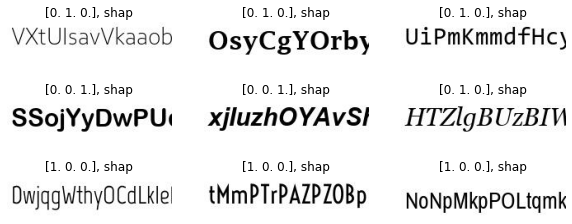

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # print(str(labels[i])[10:26])
        plt.title(str(labels[i])[10:26])
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        # layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
    ]
)

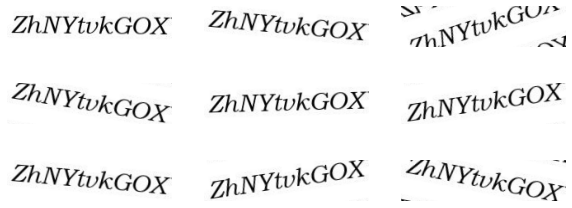

In [ ]:
plt.figure(figsize=(10, 4))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

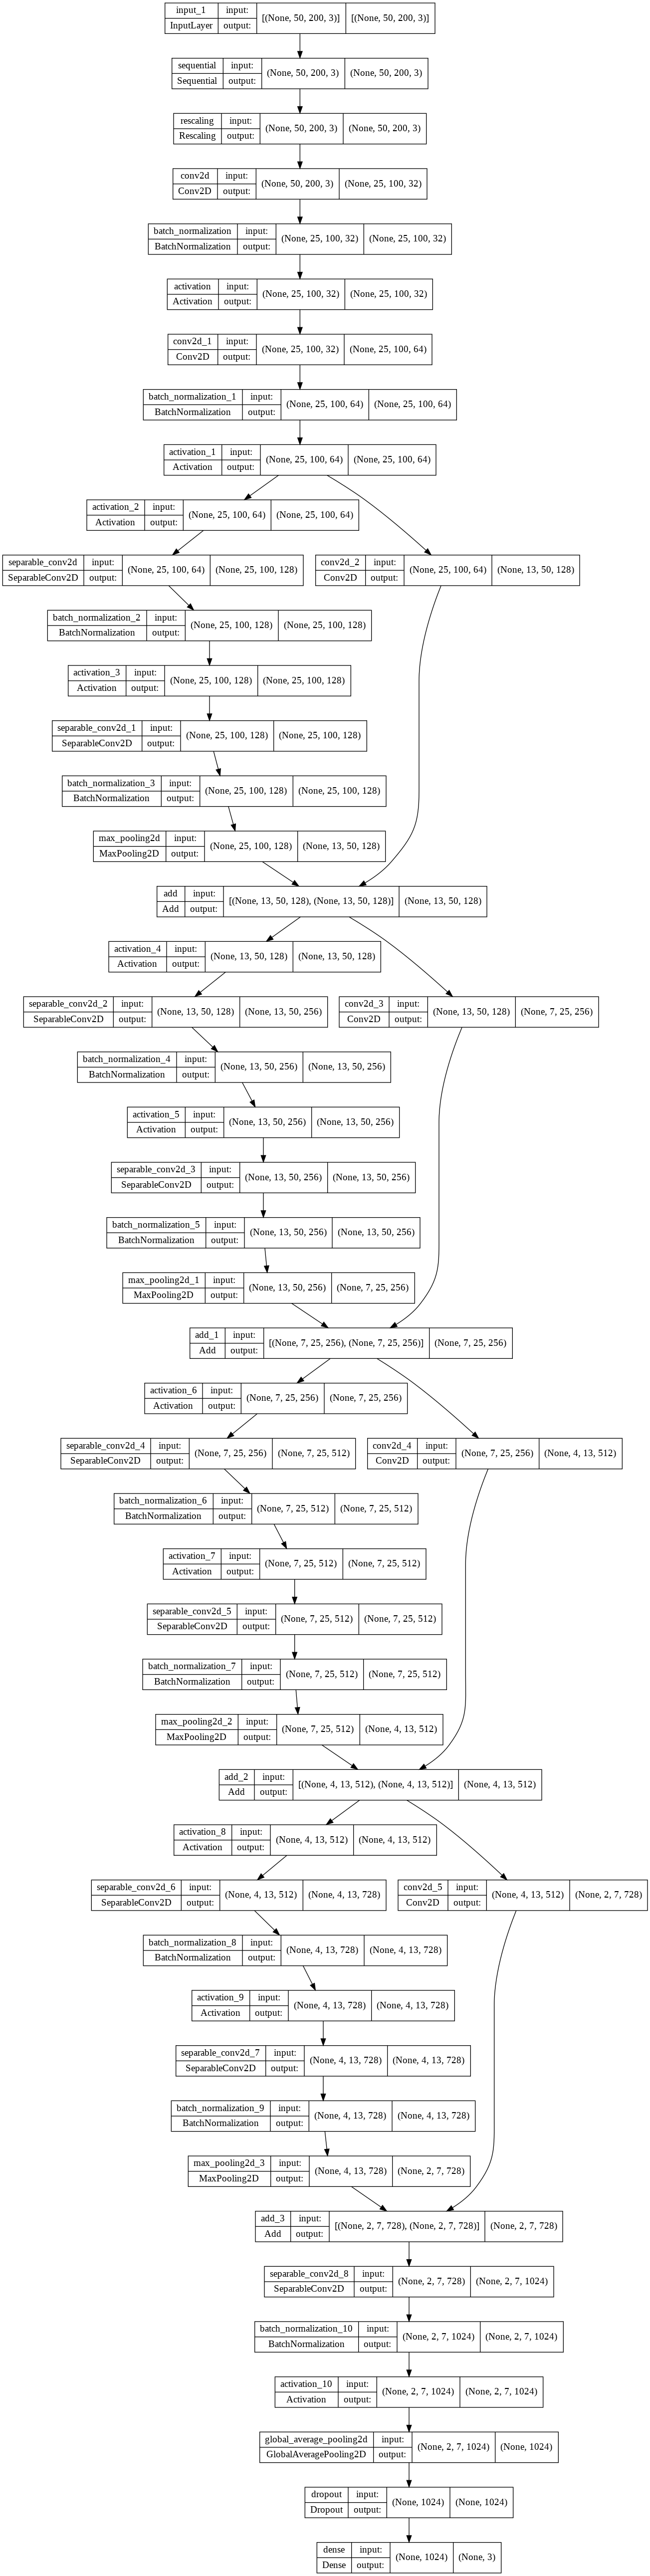

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
initial_epochs = 0
epochs = 1500

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/colabData/fontData/models/width/width_at_{epoch}#{accuracy:.3f}-{val_accuracy:.3f}.h5"),
    monitor='val_accuracy',
    save_best_only=True,
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds, initial_epoch=initial_epochs,
)

In [ ]:
initial_epoch = 100
epochs = 400

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds, initial_epoch=initial_epoch,
)

In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/colabData/fontData/data/classification/img/Monospaced/Courier Prime15.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(score)
# print(
#     "This image is %.2f percent Display || %.2f percent Sans Serif || %.2f percent Serif || %.2f percent Monospaced || %.2f percent Handwritten."
#     % (100 * score[0], 100 * score[1], 100 * score[2], 100 * score[3], 100 * score[4])
# )

[0.9736284]
